# 群落PCA

In [1]:
from openpyxl import load_workbook  
import numpy as np 
import pandas as pd  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
# pd.set_option('display.float_format', '{:.2f}'.format)  # 强制所有浮点数显示为 2 位小数
"""
伏笔，不要用下面这行
因为就算设置了两位小数，也无法阻止pandas对于过大/过小的数进行科学计数法表示的行为
可以直接针对dataframe/series中的数据进行格式化，将所有dataframe/series中的浮点数显示到小数点后两位
两者都是全局设置，运行一次即可
"""
# pd.set_option('display.precision', 2) 

'\n伏笔，不要用下面这行\n因为就算设置了两位小数，也无法阻止pandas对于过大/过小的数进行科学计数法表示的行为\n可以直接针对dataframe/series中的数据进行格式化，将所有dataframe/series中的浮点数显示到小数点后两位\n两者都是全局设置，运行一次即可\n'

### 设置中文字体

In [3]:
plt.rcParams['font.sans-serif'] = ['Simsun']
# plt.rcParams['font.sans-serif'] = ['Times new roman']
plt.rcParams['axes.unicode_minus'] = False

### 提取数据
定义一个函数，实现以下目标： 
- 分割每一个子表，用子表的名字查找
- 去除土壤数据
- 识别“群落”并且进一步把子表按月拆分，最终得到一个字典，键是月份，值是月份对应的dataframe

In [4]:
def extract_monthly_species_data(file_path, group_name):  
    """  
    提取指定群落的所有月份物种数据  
    参数：  
        file_path: Excel文件路径  
        group_name: 群落名称（"刘武井群落"、"香山台地群落"等）  
    返回：  
        monthly_data: 字典，键为月份，值为对应的物种数据DataFrame  
    """  
    monthly_data = {}  

    wb = load_workbook(filename=file_path, read_only=True)  
    try:  
        # sheetnames 获取工作簿中所有工作表的名称，并储存在 sheets 列表中  
        sheets = wb.sheetnames  

        # 查找包含group_name的子表  
        sheet_name = [s for s in sheets if group_name in s]  
        if not sheet_name:  
            raise ValueError(f"未找到名为'{group_name}'的子表!")  
        ws = wb[sheet_name[0]]    
        # print(sheet_name)
        
        current_month = None  
        header = []  
        species_rows = []  
        
        for row_idx, row in enumerate(ws.iter_rows(values_only=True), 1):  
            # 检测月份标题行（如："5月"）  
            if row[0] and "月" in str(row[0]):  
                # 保存前一个月份的数据（如果存在）  
                if current_month and species_rows:  
                    df = pd.DataFrame(species_rows, columns=header)  
                    df.set_index("物种名称", inplace=True)  
                    monthly_data[current_month] = df  
                    species_rows = []  
                
                current_month = row[0].strip()  
                header = []  
            
            # 定位表头行  
            if current_month and not header:  
                if "物种名称" in row:  
                    header = [cell for cell in row[:6] if cell is not None]  
            
            # 收集物种数据行，并确保不重复表头  
            if current_month and header and row_idx > 2 and any(row[:6]):  
                # 添加条件排除表头重复  
                if row[0] not in header:  # 确保不加入表头  
                    species_rows.append(row[:6])  
                    
        # 处理最后一个月份的数据  
        if current_month and species_rows:  
            df = pd.DataFrame(species_rows, columns=header)  
            df.set_index("物种名称", inplace=True)  
            monthly_data[current_month] = df  
    
    finally:  
        wb.close()  
    
    return monthly_data  

### 文件路径

In [5]:
file_path = "D:\\John\\生态学\\生物多样性指数计算\\第八章多样性指数计算作业数据.xlsx"  # 台式
# file_path = "D:\\John\\university\\Attention\\Diversity\\第八章多样性指数计算作业数据.xlsx"  

### 提取每一个dataframe

In [6]:
communities = [
    ("lwj", "刘武井群落"),  
    ("tcb", "同场堡群落"),  
    ("xstd", "香山台地群落"), 
    ("zjq", "朱家圈群落"),  
    ("tjs", "天井山群落"),  
    ("yyw", "月牙湾群落")   
]
months = range(5, 11)

In [7]:
for abbr, name in communities:
    monthly_data = extract_monthly_species_data(file_path, name)    # 当前群落所有月份数据，返回的是字典
    # 用lwj_5,lwj_6...yyw_10等36个变量存储每一个dataframe
    for month in months:
        dict_key = f"{name}{month}月"
        var_name = f"{abbr}_{month}"
        globals()[var_name] = monthly_data[dict_key]
# yyw_10.head()

### 将相对多度等指标和pi1……pi4等指标添加到dataframe中

In [8]:
# 组合所有变量名、群落名称、月份
df_variables = []
for abbr, name in communities:
    for month in months:
        var_name = f"{abbr}_{month}" 
        df_variables.append((var_name, name, month))

# df_variables[:5]

In [9]:
def calculate_relative_values(df, absolute_columns_list = ['高度(cm)', '频度(个)', '多度(个/m2)', '盖度(%)', '干重(g/m2)']):
    """
    目标：
        为 DataFrame 添加相对值列(相对高度、相对多度等)
    参数:
        df: 原始 DataFrame，包含绝对值列（多度、频度等）
        absolute_columns_list: 需要计算相对值的列名列表(注意放的是列表，例：['高度(cm)', '频度(个)', '多度(个/m2)', '盖度(%)', '干重(g/m2)'])
    返回:
        添加了相对值列的dataFrame
    """
    
    for col in absolute_columns_list:
        total = sum(df[col]) 
        relative_value = df[col] / total 
        df[f'相对{col[:2]}'] = relative_value

    return df

In [10]:
for var_name, name, month in df_variables: 
    df_varname = globals()[var_name] 
    globals()[var_name] = calculate_relative_values(df_varname)
yyw_10

,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2),相对高度,相对频度,相对多度,相对盖度,相对干重
物种名称,,,,,,,,,,
短花针茅,2.3500,9,32,6.0,15.5480,0.172157,0.45,0.533333,0.75,0.658668
单叶黄芪,5.3333,3,20,0.8,2.9036,0.390709,0.15,0.333333,0.10,0.123007
冷蒿,3.8000,5,4,0.4,4.2204,0.278382,0.25,0.066667,0.05,0.178791
细颈黄芪,2.1670,3,4,0.8,0.9332,0.158751,0.15,0.066667,0.10,0.039534


In [11]:
def calculate_pi(df): 
    df['pi_1'] = (df['相对高度'] + df['相对频度']) / 2
    df['pi_2'] = (df['相对高度'] + df['相对频度'] + df['相对多度']) / 3 
    df['pi_3'] = (df['相对高度'] + df['相对频度'] + df['相对多度'] + df['相对盖度']) / 4
    df['pi_4'] = (df['相对高度'] + df['相对频度'] + df['相对多度'] + df['相对盖度'] + df['相对干重']) / 5
    return df 

In [12]:
for var_name, name, month in df_variables: 
    df_varname = globals()[var_name] 
    globals()[var_name] = calculate_pi(df_varname)
yyw_10

,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2),相对高度,相对频度,相对多度,相对盖度,相对干重,pi_1,pi_2,pi_3,pi_4
物种名称,,,,,,,,,,,,,,
短花针茅,2.3500,9,32,6.0,15.5480,0.172157,0.45,0.533333,0.75,0.658668,0.311079,0.385164,0.476373,0.512832
单叶黄芪,5.3333,3,20,0.8,2.9036,0.390709,0.15,0.333333,0.10,0.123007,0.270355,0.291348,0.243511,0.219410
冷蒿,3.8000,5,4,0.4,4.2204,0.278382,0.25,0.066667,0.05,0.178791,0.264191,0.198350,0.161262,0.164768
细颈黄芪,2.1670,3,4,0.8,0.9332,0.158751,0.15,0.066667,0.10,0.039534,0.154376,0.125139,0.118854,0.102990


In [13]:
# 创建一个空列表用于存储所有数据框
all_dfs = []

for var_name, community, month in df_variables:
    df = globals()[var_name]  # 或者 locals()[var_name]
    df["群落"] = community  # 添加群落和月份列
    df["月份"] = month
    df = df.reset_index().rename(columns={"index": "物种名称"})    # 将索引（物种名称）转换为列
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.set_index(['物种名称'])
combined_df

,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2),相对高度,相对频度,相对多度,相对盖度,相对干重,pi_1,pi_2,pi_3,pi_4,群落,月份
物种名称,,,,,,,,,,,,,,,,
短花针茅,5.7800,10,37.333333,11.801653,6.933467,0.019630,0.217391,0.333343,0.467344,0.527601,0.118511,0.190122,0.259427,0.313062,刘武井群落,5
梯牧草,2.7300,8,29.333333,7.000000,4.328533,0.009272,0.173913,0.261913,0.277199,0.329379,0.091592,0.148366,0.180574,0.210335,刘武井群落,5
蚓果芥,4.1200,9,21.333333,0.550964,1.296400,0.013992,0.195652,0.190482,0.021818,0.098649,0.104822,0.133375,0.105486,0.104119,刘武井群落,5
柠条锦鸡儿,62.0000,0,0.666667,4.100000,0.000000,0.210564,0.000000,0.005953,0.162359,0.000000,0.105282,0.072172,0.094719,0.075775,刘武井群落,5
小叶锦鸡儿,45.3750,1,0.000000,0.000000,0.000000,0.154103,0.021739,0.000000,0.000000,0.000000,0.087921,0.058614,0.043960,0.035168,刘武井群落,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
柴胡,0.0000,0,4.000000,1.200000,2.028000,0.000000,0.000000,0.035714,0.037037,0.025632,0.000000,0.011905,0.018188,0.019677,月牙湾群落,9
短花针茅,2.3500,9,32.000000,6.000000,15.548000,0.172157,0.450000,0.533333,0.750000,0.658668,0.311079,0.385164,0.476373,0.512832,月牙湾群落,10
单叶黄芪,5.3333,3,20.000000,0.800000,2.903600,0.390709,0.150000,0.333333,0.100000,0.123007,0.270355,0.291348,0.243511,0.219410,月牙湾群落,10


In [14]:
combined_df_5 = combined_df[combined_df['月份'] == 5]
combined_df_6 = combined_df[combined_df['月份'] == 6] 
combined_df_7 = combined_df[combined_df['月份'] == 7] 
combined_df_8 = combined_df[combined_df['月份'] == 8] 
combined_df_9 = combined_df[combined_df['月份'] == 9] 
combined_df_10 = combined_df[combined_df['月份'] == 10] 
combined_df_8

,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2),相对高度,相对频度,相对多度,相对盖度,相对干重,pi_1,pi_2,pi_3,pi_4,群落,月份
物种名称,,,,,,,,,,,,,,,,
长芒草,9.800,11,7.90,13.740,6.3500,0.061648,0.159420,0.398386,0.405549,0.468486,0.110534,0.206485,0.256251,0.298698,刘武井群落,8
冷蒿,11.700,7,2.80,5.200,4.1869,0.073601,0.101449,0.141200,0.153483,0.308898,0.087525,0.105417,0.117433,0.155726,刘武井群落,8
扁穗冰草,4.167,8,2.55,3.300,2.2560,0.026213,0.115942,0.128593,0.097403,0.166442,0.071078,0.090249,0.092038,0.106918,刘武井群落,8
梯牧草,4.700,10,2.85,2.880,0.0000,0.029566,0.144928,0.143722,0.085006,0.000000,0.087247,0.106072,0.100805,0.080644,刘武井群落,8
柠条锦鸡儿,61.300,1,0.00,0.000,0.0000,0.385617,0.014493,0.000000,0.000000,0.000000,0.200055,0.133370,0.100027,0.080022,刘武井群落,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
细颈黄芪,4.100,4,4.00,0.375,0.3285,0.039131,0.063492,0.066667,0.007504,0.005389,0.051312,0.056430,0.044198,0.036437,月牙湾群落,8
花花柴,5.700,4,1.00,0.550,0.1803,0.054402,0.063492,0.016667,0.011006,0.002958,0.058947,0.044854,0.036392,0.029705,月牙湾群落,8
单叶黄芪,5.100,3,1.00,0.200,0.1540,0.048676,0.047619,0.016667,0.004002,0.002527,0.048147,0.037654,0.029241,0.023898,月牙湾群落,8


### 演替度和稳定性的计算

In [15]:
# wb_month_8 = pd.read_excel('C:\\Users\\John\\Desktop\\8月数据副本.xlsx')
wb_month_8 = pd.read_excel('C:\\Users\\Administrator\\Desktop\\8月数据副本.xlsx') # 台式

df_lifestyle_8 = pd.DataFrame(wb_month_8)
# df1的索引顺序会被保留
df_lifestyle_8.set_index('物种名称',inplace= True)
df_lifestyle_8 = pd.concat([combined_df_8, df_lifestyle_8], axis=1)
df_lifestyle_8 = df_lifestyle_8[df_lifestyle_8['pi_4'] != 0]

In [16]:
df = df_lifestyle_8
lwj_lifestyle = df[df['群落'] == '刘武井群落']
tjs_lifestyle = df[df['群落'] == '天井山群落'] 
xstd_lifestyle = df[df['群落'] == '香山台地群落'] 
tcb_lifestyle = df[df['群落'] == '同场堡群落'] 
yyw_lifestyle = df[df['群落'] == '月牙湾群落'] 
zjq_lifestyle = df[df['群落'] == '朱家圈群落'] 

In [56]:
def lifestyle(df):
    df.loc[:, "演替度"] = sum(df['盖度(%)'])/100 * sum(df['生活型'] * df['pi_4'] / len(df)) 
    ds = sum(df['演替度'])
    return df, ds

lwj_lifestyle, ds_lwj = lifestyle(lwj_lifestyle)
tjs_lifestyle, ds_tjs = lifestyle(tjs_lifestyle)
xstd_lifestyle, ds_xstd = lifestyle(xstd_lifestyle)
tcb_lifestyle, ds_tcb = lifestyle(tcb_lifestyle)
yyw_lifestyle, ds_yyw = lifestyle(yyw_lifestyle)
zjq_lifestyle, ds_zjq = lifestyle(zjq_lifestyle)

print('演替度DS:')
print(
    f"刘武井群落：{ds_lwj:.2f}, \n同场堡群落：{ds_tcb:.2f}, \n天井山群落：{ds_tjs:.2f}, \n香山台地群落：{ds_xstd:.2f}, \n月牙湾群落：{ds_yyw:.2f}, \n朱家圈群落：{ds_zjq:.2f}")

演替度DS:
刘武井群落：4.91, 
同场堡群落：2.92, 
天井山群落：9.10, 
香山台地群落：20.27, 
月牙湾群落：8.43, 
朱家圈群落：7.95


In [53]:
def tilman_stability(df):
    """
    计算Tilman稳定性指数
    参数:df
    返回:稳定性指数
    """
    mu = df['干重(g/m2)'].mean()  # 平均值
    sigma = df['干重(g/m2)'].std()  # 标准差
    return mu / sigma 
    
tilman_lwj = tilman_stability(lwj_lifestyle)
tilman_xstd = tilman_stability(xstd_lifestyle)
tilman_tjs = tilman_stability(tjs_lifestyle)
tilman_tcb = tilman_stability(tcb_lifestyle)
tilman_yyw = tilman_stability(yyw_lifestyle)
tilman_zjq = tilman_stability(zjq_lifestyle)

print('Tilman稳定性常数:')
print(
    f"刘武井群落：{tilman_lwj:.4f}, \n同场堡群落：{tilman_tcb:.4f}, \n天井山群落：{tilman_tjs:.4f}, \n香山台地群落：{tilman_xstd:.4f}, \n月牙湾群落：{tilman_yyw:.4f}, \n朱家圈群落：{tilman_zjq:.4f}")

Tilman稳定性常数:
刘武井群落：0.3546, 
同场堡群落：1.2143, 
天井山群落：0.2929, 
香山台地群落：0.2525, 
月牙湾群落：0.5260, 
朱家圈群落：0.5570


In [47]:
def var_stability(df):
    """
    计算方差稳定性指数
    参数:df
    返回:稳定性指数
    """
    var = df['干重(g/m2)'].var()  
    return 1 / var  

var_lwj = var_stability(lwj_lifestyle)
var_xstd = var_stability(xstd_lifestyle)
var_tjs = var_stability(tjs_lifestyle)
var_tcb = var_stability(tcb_lifestyle)
var_yyw = var_stability(yyw_lifestyle)
var_zjq = var_stability(zjq_lifestyle)

print('方差稳定性常数:')
print(
    f"刘武井群落：{var_lwj:.4f}, \n同场堡群落：{var_tcb:.4f}, \n天井山群落：{var_tjs:.4f}, \n香山台地群落：{var_xstd:.4f}, \n月牙湾群落：{var_yyw:.4f}, \n朱家圈群落：{var_zjq:.4f}")

方差稳定性常数:
刘武井群落：0.4277, 
同场堡群落：0.0842, 
天井山群落：0.4085, 
香山台地群落：0.0078, 
月牙湾群落：0.0126, 
朱家圈群落：0.0072


In [64]:
df = pd.DataFrame({
    "DS": [ds_lwj, ds_tjs, ds_xstd, ds_tcb, ds_yyw, ds_zjq],  
    "Tilman": [tilman_lwj, tilman_tjs, tilman_xstd, tilman_tcb, tilman_yyw, tilman_zjq], 
    "VIS": [var_lwj, var_tjs, var_xstd, var_tcb, var_yyw, var_zjq], 
}, index=['刘武井群落', '天井山群落', '香山台地群落', '同场堡群落', '月牙湾群落', '朱家圈群落'])
df

,DS,Tilman,VIS
刘武井群落,4.905250,0.354570,0.427690
天井山群落,9.104750,0.292931,0.408473
香山台地群落,20.272893,0.252541,0.007764
同场堡群落,2.920000,1.214286,0.084228
月牙湾群落,8.427287,0.525975,0.012584
朱家圈群落,7.946007,0.557003,0.007187


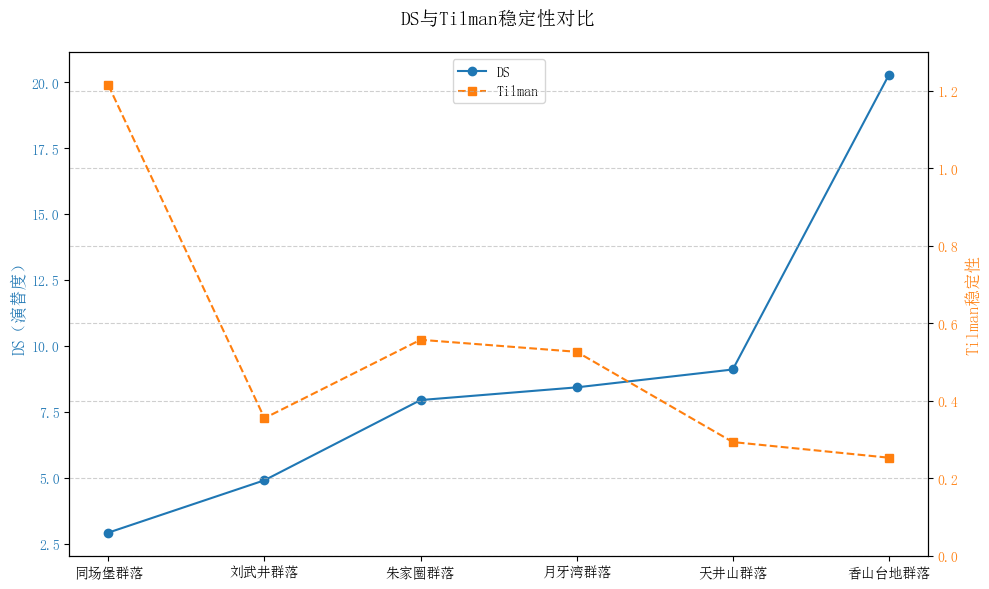

In [73]:
# 交给AI
import matplotlib.pyplot as plt

# 按DS列从小到大排序
df_sorted = df.sort_values(by="DS").reset_index(drop=True)

# 创建画布和主坐标轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制DS折线图（主Y轴）
ax1.plot(df_sorted["群落名称"], df_sorted["DS"], 
         marker="o", linestyle="-", color="#1f77b4", label="DS")
# ax1.set_xlabel("群落名称（按DS排序）", fontsize=12)
ax1.set_ylabel("DS（演替度）", fontsize=12, color="#1f77b4")
ax1.tick_params(axis="y", labelcolor="#1f77b4")

# 创建次坐标轴（用于Tilman，调整间距）
ax2 = ax1.twinx()
ax2.plot(df_sorted["群落名称"], df_sorted["Tilman"], 
         marker="s", linestyle="--", color="#ff7f0e", label="Tilman")
ax2.set_ylabel("Tilman稳定性", fontsize=12, color="#ff7f0e")
ax2.tick_params(axis="y", labelcolor="#ff7f0e")

# 调整Tilman纵轴范围（使变化趋势更明显）
ax2.set_ylim(0, 1.3)  # 根据数据范围手动设置

# 添加图例和标题
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

plt.title("DS与Tilman稳定性对比", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
# pd.set_option('display.max_rows', 110)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

df = combined_df

df = df[df['pi_4'] != 0]
# df = df.loc[: , df.columns != '月份']

# df.to_excel('df_output.xlsx', index=True) 

df = df.reset_index()

# df['合并列'] = df['A'].str.cat(df['B'], sep=' - ')  # 参格格式
# df['sample'] = df['物种名称'] .str.cat(df['群落'], sep='-')
df['sample'] = df['物种名称'].astype(str) + '-' + df['群落'].astype(str) + '-' + df['月份'].astype(str) + '月'

df = df.drop(labels=['群落', '物种名称', '月份'],axis=1)
df = df.set_index('sample')
df

,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2),相对高度,相对频度,相对多度,相对盖度,相对干重,pi_1,pi_2,pi_3,pi_4
sample,,,,,,,,,,,,,,
短花针茅-刘武井群落-5月,5.7800,10,37.333333,11.801653,6.933467,0.019630,0.217391,0.333343,0.467344,0.527601,0.118511,0.190122,0.259427,0.313062
梯牧草-刘武井群落-5月,2.7300,8,29.333333,7.000000,4.328533,0.009272,0.173913,0.261913,0.277199,0.329379,0.091592,0.148366,0.180574,0.210335
蚓果芥-刘武井群落-5月,4.1200,9,21.333333,0.550964,1.296400,0.013992,0.195652,0.190482,0.021818,0.098649,0.104822,0.133375,0.105486,0.104119
柠条锦鸡儿-刘武井群落-5月,62.0000,0,0.666667,4.100000,0.000000,0.210564,0.000000,0.005953,0.162359,0.000000,0.105282,0.072172,0.094719,0.075775
小叶锦鸡儿-刘武井群落-5月,45.3750,1,0.000000,0.000000,0.000000,0.154103,0.021739,0.000000,0.000000,0.000000,0.087921,0.058614,0.043960,0.035168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
柴胡-月牙湾群落-9月,0.0000,0,4.000000,1.200000,2.028000,0.000000,0.000000,0.035714,0.037037,0.025632,0.000000,0.011905,0.018188,0.019677
短花针茅-月牙湾群落-10月,2.3500,9,32.000000,6.000000,15.548000,0.172157,0.450000,0.533333,0.750000,0.658668,0.311079,0.385164,0.476373,0.512832
单叶黄芪-月牙湾群落-10月,5.3333,3,20.000000,0.800000,2.903600,0.390709,0.150000,0.333333,0.100000,0.123007,0.270355,0.291348,0.243511,0.219410


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :14] # 提取特征

# 标准化数据（消除量纲影响）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
from sklearn.decomposition import PCA

# 降维至2个主成分
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# 创建包含主成分的DataFrame
pca_df = pd.DataFrame(
    data=principal_components,
    columns=["PC1", "PC2"],
    index=df.index
)

# 从样本名称中提取群落名称
pca_df["群落"] = [name.split("-")[1].strip() for name in pca_df.index]

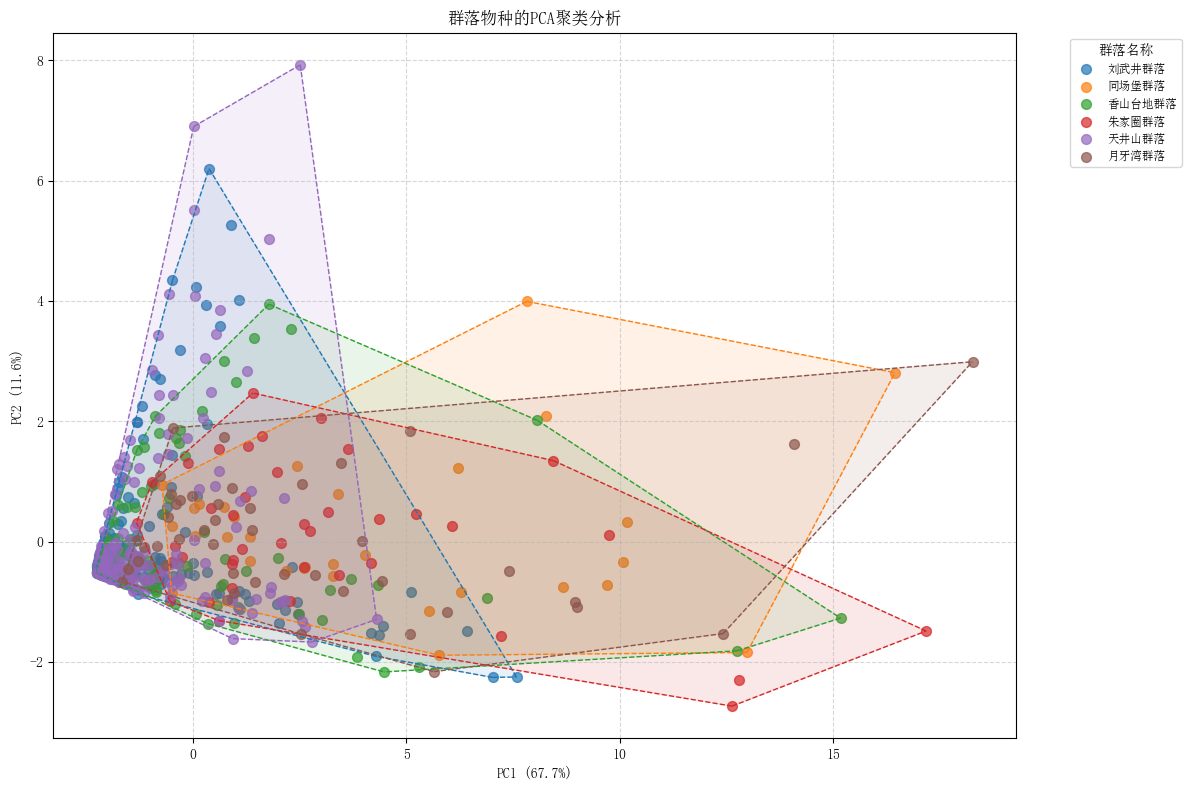

In [23]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


plt.figure(figsize=(12, 8))
for i, community in enumerate(pca_df["群落"].unique()):
    subset = pca_df[pca_df["群落"] == community]
    # 绘制散点
    plt.scatter(subset["PC1"], subset["PC2"], label=community, alpha=0.7, s=50)
    
    # 计算凸包
    if len(subset) >= 3:  # 至少需要3个点才能形成凸包
        points = subset[["PC1", "PC2"]].values
        hull = ConvexHull(points)
        # 绘制多边形
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 
                     color=plt.cm.tab10(i % 10), lw=1, ls='--')
        # 填充颜色（可选）
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 
                 color=plt.cm.tab10(i % 10), alpha=0.1)

# 添加标签和标题
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.title("群落物种的PCA聚类分析")

# 调整图例位置
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="群落名称",
    fontsize="small"
)

plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
data_dict = {
    '刘武井群落':{5:lwj_5, 6:lwj_6, 7:lwj_7, 8:lwj_8, 9:lwj_9, 10:lwj_10},
    '香山台地群落':{5:xstd_5, 6:xstd_6, 7:xstd_7, 8:xstd_8, 9:xstd_9, 10:xstd_10},
    '天井山群落':{5:tjs_5, 6:tjs_6, 7:tjs_7, 8:tjs_8, 9:tjs_9, 10:tjs_10},
    '同场堡群落':{5:tcb_5, 6:tcb_6, 7:tcb_7, 8:tcb_8, 9:tcb_9, 10:tcb_10},
    '月牙湾群落':{5:yyw_5, 6:yyw_6, 7:yyw_7, 8:yyw_8, 9:yyw_9, 10:yyw_10},
    '朱家圈群落':{5:zjq_5, 6:zjq_6, 7:zjq_7, 8:zjq_8, 9:zjq_9, 10:zjq_10},
}

In [25]:
# def load_month_data(data_dict, month):

#     # 提取所有群落数据
#     community_names = list(data_dict.keys())
#     samples = []
    
#     for community in data_dict:
#         df = data_dict[community][month] 
#         df.reset_index(inplace=True)
#         # print(df)
#         abundance = df.set_index("物种名称")["pi_4"].to_dict()
#         # print(abundance)
#         samples.append(abundance)
    
#     # 转换为样本×物种的矩阵
#     matrix = pd.DataFrame(samples, index=community_names).fillna(0)
#     # species_matrix = matrix.values
#     return matrix
    
    # def bray_curtis(u, v):
    #     # 计算分子：两样本共有物种的最小值之和
    #     min_sum = np.minimum(u, v).sum()
    #     # 计算分母：两样本总丰度之和
    #     total_sum = u.sum() + v.sum()
    #     # 避免除以零（如果两样本总丰度均为0，则相异性为0）
    #     return 1 - (2 * min_sum / total_sum) if total_sum != 0 else 0
    
    # # 计算所有样本对的相异性矩阵
    # n_samples = len(community_names)
    # bc_matrix = np.zeros((n_samples, n_samples))
    
    # for i in range(n_samples):
    #     for j in range(n_samples):
    #         bc_matrix[i, j] = bray_curtis(species_matrix[i], species_matrix[j])
    
    # # 转换为带标签的DataFrame
    # matrix = pd.DataFrame(bc_matrix, index=community_names, columns=community_names)

    # return matrix

In [26]:
# matrix_5 = load_month_data(data_dict, 5).T
# matrix_6 = load_month_data(data_dict, 6).T
# matrix_7 = load_month_data(data_dict, 7).T
# matrix_8 = load_month_data(data_dict, 8).T 
# matrix_9 = load_month_data(data_dict, 9).T 
# matrix_10 = load_month_data(data_dict, 10).T 

# # average_matrix = (matrix_10+matrix_5+matrix_6+matrix_7+matrix_8+matrix_9)/6

In [27]:
# # 显示所有列
# pd.set_option('display.max_columns', None)

# # 显示所有行
# pd.set_option('display.max_rows', None)

In [28]:
# df = matrix_6 
# df = df[(df != 0).any(axis=1)]
# df
# # sum(df['香山台地群落'])